In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from safetensors.torch import load_model, save_model
from torch.utils.data import DataLoader
from sklearn.metrics import mean_squared_error
from sklearn import model_selection, preprocessing

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
df_movie = pd.read_csv('data/movies.csv')
df_ratings = pd.read_csv('data/ratings.csv')

In [4]:
df_movie.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471
3,1,1257,4.5,1256677460
4,1,1449,4.5,1256677264


In [6]:
df_movie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58098 entries, 0 to 58097
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  58098 non-null  int64 
 1   title    58098 non-null  object
 2   genres   58098 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.3+ MB


In [7]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27753444 entries, 0 to 27753443
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 847.0 MB


In [8]:
df_ratings.describe()

,userId,movieId,rating,timestamp
count,2.775344e+07,2.775344e+07,2.775344e+07,2.775344e+07
mean,1.419420e+05,1.848800e+04,3.530445e+00,1.193122e+09
std,8.170740e+04,3.510263e+04,1.066353e+00,2.160482e+08
min,1.000000e+00,1.000000e+00,5.000000e-01,7.896520e+08
25%,7.117600e+04,1.097000e+03,3.000000e+00,9.986053e+08
50%,1.420220e+05,2.716000e+03,3.500000e+00,1.174256e+09
75%,2.124590e+05,7.150000e+03,4.000000e+00,1.422744e+09
max,2.832280e+05,1.938860e+05,5.000000e+00,1.537945e+09


In [9]:
print(f"unique userId: {df_ratings.userId.nunique()}\n\
unique movieId: {df_ratings.movieId.nunique()}\n\
unique rating: {df_ratings.rating.nunique()}")

unique userId: 283228
unique movieId: 53889
unique rating: 10


In [10]:
df_ratings.rating.value_counts()

4.0    7394710
3.0    5515668
5.0    4071135
3.5    3404360
4.5    2373550
2.0    1850627
2.5    1373419
1.0     886233
0.5     442388
1.5     441354
Name: rating, dtype: int64

#### Dataset

In [11]:
from collaborative_filtering_model import MovieDataset

#### Model

In [12]:
class RecommendSysModel(nn.Module):
    def __init__(self, n_users, n_movies):
        super().__init__()

        self.user_embed = nn.Embedding(n_users, 32)
        self.movie_embed = nn.Embedding(n_movies, 32)

        self.out = nn.Linear(64,1)
    
    def forward(self, users, movies, rating=None):
        user_embeds = self.user_embed(users)
        movie_embeds = self.movie_embed(movies)
        output = torch.cat([user_embeds, movie_embeds],dim=1)
        output = self.out(output)
        return output
    

#### Data Prep

In [13]:
label_user = preprocessing.LabelEncoder()
label_movie = preprocessing.LabelEncoder()
df_ratings.userId = label_user.fit_transform(df_ratings.userId.values)
df_ratings.movieId = label_movie.fit_transform(df_ratings.movieId.values)

In [14]:
df_train, df_val = model_selection.train_test_split(df_ratings, test_size=0.1, random_state=42,stratify=df_ratings.rating.values)

train_dataset = MovieDataset(users=df_train.userId.values, 
                             movies=df_train.movieId.values,
                             ratings=df_train.rating.values
                             )

val_dataset = MovieDataset(users=df_val.userId.values, 
                             movies=df_val.movieId.values,
                             ratings=df_val.rating.values
                             )

In [15]:
train_loader = DataLoader(dataset=train_dataset, batch_size=2048, shuffle=True, num_workers=4)
val_loader = DataLoader(dataset=val_dataset, batch_size=2048, shuffle=True, num_workers=4)



In [16]:
model = RecommendSysModel(n_users=len(label_user.classes_), n_movies=len(label_movie.classes_)).to(device)

optimizer = torch.optim.Adam(model.parameters())
sch = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=1024, gamma=0.9)

loss_func = nn.MSELoss()

#### PCA

In [17]:
from sklearn.decomposition import PCA

In [18]:
users = df_ratings.userId.values
movies = df_ratings.movieId.values
ratings = df_ratings.rating.values

In [19]:
feature_matrix = np.column_stack((users, movies))

In [20]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(feature_matrix)

In [21]:
import plotly.express as px
import matplotlib.image as mpimg

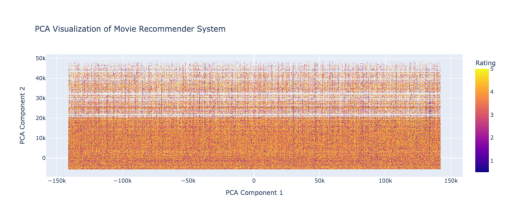

In [22]:
# df_pca = pd.DataFrame({'PCA Component 1': pca_result[:, 0], 'PCA Component 2': pca_result[:, 1], 'Rating': ratings})
# # due to the large amount of items, randomly choose 25% of the data to visualize
# df_pca_subset = df_pca.sample(n=6938361)
# fig = px.scatter(df_pca_subset, x='PCA Component 1', y='PCA Component 2', color='Rating', title='PCA Visualization of Movie Recommender System')
# fig.update_traces(marker=dict(size=1))
# fig.show()

# for storage concern, I'll load the image instead of run the plot
img = mpimg.imread("PCA_plot.png")
plt.imshow(img)
plt.axis('off')
plt.show()

#### Start training 

In [23]:
epochs = 1
total_loss = 0
plot_steps, print_steps = 204800, 204800
step_cnt = 0
all_losses_list = [] 

In [24]:
model.train()
for epoch in range(epochs):
    for i, train_data in enumerate(train_loader):
        output = model(train_data["users"],train_data["movies"])
        rating = train_data["ratings"].view(train_data["ratings"].size(0),-1).to(torch.float32)

        if len(train_data) < 2048:
            num_leftover = len(train_data["users"])
            padding = torch.zeros(2048 - num_leftover, rating.size(1)).to(torch.float32)
            rating = torch.cat((rating, padding),dim=0)
            output = torch.cat((output, padding),dim=0)

        loss = loss_func(output, rating)
        total_loss += loss.sum().item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        step_cnt += len(train_data["users"])

        if (step_cnt % plot_steps == 0):
            avg_loss = total_loss/plot_steps
            print(f"epoch : {epoch} loss at step : {step_cnt} is : {avg_loss}")
            all_losses_list.append(avg_loss)
            total_loss = 0

epoch : 0 loss at step : 204800 is : 0.005761476722545922
epoch : 0 loss at step : 409600 is : 0.004492347869090736
epoch : 0 loss at step : 614400 is : 0.0029372229683212936
epoch : 0 loss at step : 819200 is : 0.0019320518313907086
epoch : 0 loss at step : 1024000 is : 0.001429019425995648
epoch : 0 loss at step : 1228800 is : 0.00115045654354617
epoch : 0 loss at step : 1433600 is : 0.0009878935082815587
epoch : 0 loss at step : 1638400 is : 0.0008975297817960382
epoch : 0 loss at step : 1843200 is : 0.0008189455850515514
epoch : 0 loss at step : 2048000 is : 0.0007729294744785875
epoch : 0 loss at step : 2252800 is : 0.0007356326846638694
epoch : 0 loss at step : 2457600 is : 0.0007034321659011766
epoch : 0 loss at step : 2662400 is : 0.000693170857266523
epoch : 0 loss at step : 2867200 is : 0.0006724407768342644
epoch : 0 loss at step : 3072000 is : 0.0006527762085897848
epoch : 0 loss at step : 3276800 is : 0.0006336733227362856
epoch : 0 loss at step : 3481600 is : 0.0006283198

In [25]:
save_model(model, "collaborative_filtering_model.safetensors")
# load_model(model, "collaborative_filtering_model.safetensors")

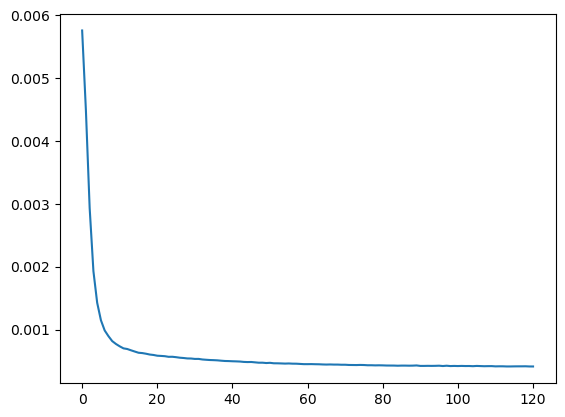

In [26]:
plt.figure()
plt.plot(all_losses_list)
plt.show()

#### Evaluation with RMSE

In [27]:
model_output_list = []
target_rating_list = []

model.eval()

with torch.no_grad():
    for i, batch_data in enumerate(val_loader):
        model_output = (model(batch_data["users"],batch_data["movies"]).sum().numpy())/batch_data["users"].size(0)
        model_output_list.append(model_output)
        target_rating = (batch_data["ratings"].sum().float().numpy())/batch_data["ratings"].size(0)
        target_rating_list.append(target_rating)

rmse = mean_squared_error(target_rating_list, model_output_list, squared=False)
print(f"RMSE : {rmse}")

RMSE : 0.02156440626599154
